### **A2.2 LDA y Árboles de Decisión.ipynb**

**1.** Primero se **importan los datos** y se separan en entrenamiento y prueba.

*En este caso, la base de datos es muy grande, ya que cuenta con 21263 observaciones y debido a que más adelante se utilza un proceso de validación cruzada el cual es muy tardado de ejecutar en condiciones normales, se utilizará una proporción 1-99, con 1% de datos de entrenamiento y 99% datos de prueba, lo cual sigue dando aproximadamente 200 observaciones de entrenamiento.*

Se utiliza el parámeto `stratify = y` para **mantener una proporción igual** en entrenamiento y prueba y se imprimen dichas proporciones para comprobar que exista **consistencia**.

In [266]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('train.csv')
temp_prom = df['critical_temp'].mean()
print("Temperatura Critica Promedio:", temp_prom)
df['high_temp'] = (df['critical_temp'] >= temp_prom).astype(int)
df = df.drop(columns = 'critical_temp')
y = df['high_temp']
x = df.drop(columns = ['high_temp'])
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=23, stratify=y)
prop_og = df['high_temp'].value_counts(normalize=True)
prop_train = y_train.value_counts(normalize=True)
prop_test = y_test.value_counts(normalize=True)
print("Proporcion de clase 1 en dataset original:",prop_og)
print("Proporcion de clase 1 en dataset de entrenamiento:",prop_train)
print("Proporcion de clase 1 en dataset de prueba:",prop_test)

Temperatura Critica Promedio: 34.42121913535249
Proporcion de clase 1 en dataset original: high_temp
0    0.623054
1    0.376946
Name: proportion, dtype: float64
Proporcion de clase 1 en dataset de entrenamiento: high_temp
0    0.623045
1    0.376955
Name: proportion, dtype: float64
Proporcion de clase 1 en dataset de prueba: high_temp
0    0.62309
1    0.37691
Name: proportion, dtype: float64


**2.** En la siguiente celda se genera un modelo de **regresión logística simple** utilizando la librería `statsmodels.api` y su función `GLM`, esto se hace con el objetivo de obtener información relevante acerca de que **variables son relevantes** para el estudio y poder trabajar solo con aquellas que lo sean.

In [267]:
import statsmodels.api as sm

x_train = sm.add_constant(x_train)
model = sm.GLM(y_train, x_train, family=sm.families.Binomial())
result = model.fit()

print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              high_temp   No. Observations:                17010
Model:                            GLM   Df Residuals:                    16928
Model Family:                Binomial   Df Model:                           81
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3665.6
Date:                Thu, 20 Mar 2025   Deviance:                       7331.2
Time:                        04:35:05   Pearson chi2:                 6.55e+04
No. Iterations:                    11   Pseudo R-squ. (CS):             0.5910
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

En el resumen, se encuentran principalmente significantes las variables:

- entropy_Valence con p < 0.05 y coeficiente de 37.82
- entropy_atomic_radius con p < 0.05 y coeficiente de -24.76

Se mantienen solamente estas dos variables y se borran las demás a partir de este punto.


**3.** Ahora se genera un modelo utilizando la metodología de **linear discriminant analysis** con la función del mismo nombre de la librería `sklearn.discriminant_analysis`.

Antes de generar el modelo, se **estandarizan los datos** utilizando la función `StandardScaler` de `sklearn.preprocessing.`

Una vez estandarizados, se gráfica el modelo de LDA comparando entropy_Valence y entropy_atomic_radius ya estandarizadas, mostrando **temperaturas altas en rojo y bajas en azul** segun la clase a la que pertenecen los datos

Estandarización:
entropy_atomic_radius:
Antes: 1.2564656672902879 ( 0.37158649213471123 )
Después: -8.462832112237042e-16 ( 1.002366867216236 )
entropy_Valence:
Antes: 1.2831225473270678 ( 0.3906118653215481 )
Después: 2.765083759443786e-16 ( 1.0023668672162362 )


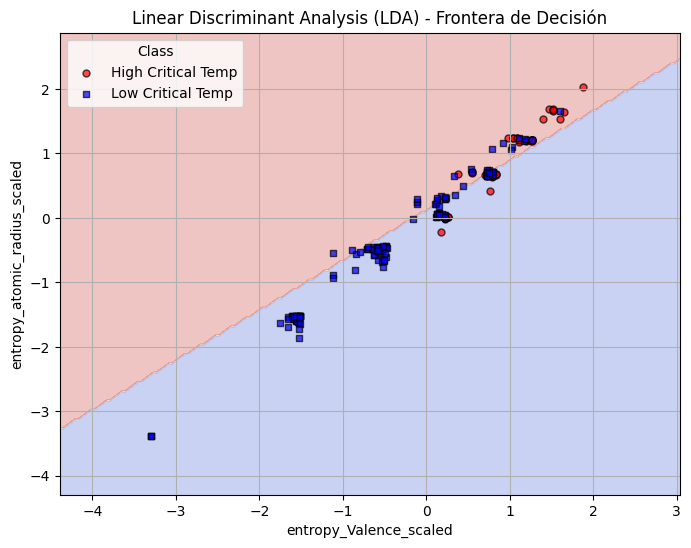

In [268]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.99,random_state=23, stratify=y)

x_train = x_train.copy()
x_test = x_test.copy()

x_train = x_train[['entropy_atomic_radius','entropy_Valence']]
x_test = x_test[['entropy_atomic_radius','entropy_Valence']]

x_train['entropy_atomic_radius_scaled'] = StandardScaler().fit_transform(x_train[['entropy_atomic_radius']])
x_train['entropy_Valence_scaled'] = StandardScaler().fit_transform(x_train[['entropy_Valence']])

x_test['entropy_atomic_radius_scaled'] = StandardScaler().fit_transform(x_test[['entropy_atomic_radius']])
x_test['entropy_Valence_scaled'] = StandardScaler().fit_transform(x_test[['entropy_Valence']])

x_test = x_test.drop(columns = ['entropy_Valence','entropy_atomic_radius'])
print("Estandarización:")
print("entropy_atomic_radius:")
print("Antes:",x_train['entropy_atomic_radius'].mean(),"(",x_train['entropy_atomic_radius'].std(),")")
print("Después:",x_train['entropy_atomic_radius_scaled'].mean(),"(",x_train['entropy_atomic_radius_scaled'].std(),")")
print("entropy_Valence:")
print("Antes:",x_train['entropy_Valence'].mean(),"(",x_train['entropy_Valence'].std(),")")
print("Después:",x_train['entropy_Valence_scaled'].mean(),"(",x_train['entropy_Valence_scaled'].std(),")")

x_train = x_train.drop(columns = ['entropy_Valence','entropy_atomic_radius'])


lda = LDA()
lda.fit(x_train,y_train)

x_min, x_max = x_train.iloc[:, 0].min() - 1, x_train.iloc[:, 0].max() + 1
y_min, y_max = x_train.iloc[:, 1].min() - 1, x_train.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = x_train.columns)

Z = lda.predict(grid_df)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

markers = {True: 'o', False: 's'}
colors = {True: 'red', False: 'blue'}
classes = {True: 'High', False: 'Low'}

for class_label in [True, False]:
    plt.scatter(
        x_train.loc[y_train == class_label, 'entropy_Valence_scaled'],
        x_train.loc[y_train == class_label, 'entropy_atomic_radius_scaled'],
        c=colors[class_label], marker=markers[class_label], edgecolor='k', label=f"{classes[class_label]} Critical Temp", alpha=0.7,s=25
    )

#plt.scatter(x_train.iloc[:, 0], x_train.iloc[:, 1], c=y_train, cmap='coolwarm', marker='o', edgecolor='k', alpha= 0.8)
plt.xlabel("entropy_Valence_scaled")
plt.ylabel("entropy_atomic_radius_scaled")
plt.title("Linear Discriminant Analysis (LDA) - Frontera de Decisión")

plt.legend(title="Class")
plt.grid(True)
plt.show()

**4.** Ahora se genera un modelo utilizando la metodología de **árboles de decisión**. Esto se hace utilizando las funciones `DecisionTreeClassifier` de `sklearn.tree` y se puede visualizar utilizando `plot_tree`.

Una vez hecho el modelo, se procede a **podarlo** seleccionando el **valor óptimo de alpha** con un proceso de **validación cruzada Leave One Out**. (*Por este paso, es que se usa solo el 1% del dataset ya que al ser muchas observaciónes, generar más de 15000 modelos resulta muy exigente a nivel computacional*)

Una vez hecho esto, se imprime el valor óptimo de alpha encontrado, se visuliza el árbol podado resultando y una gráfica donde se observan las secciones hechas comparando ambas variables.

Best alpha: 0.004196787148594378


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


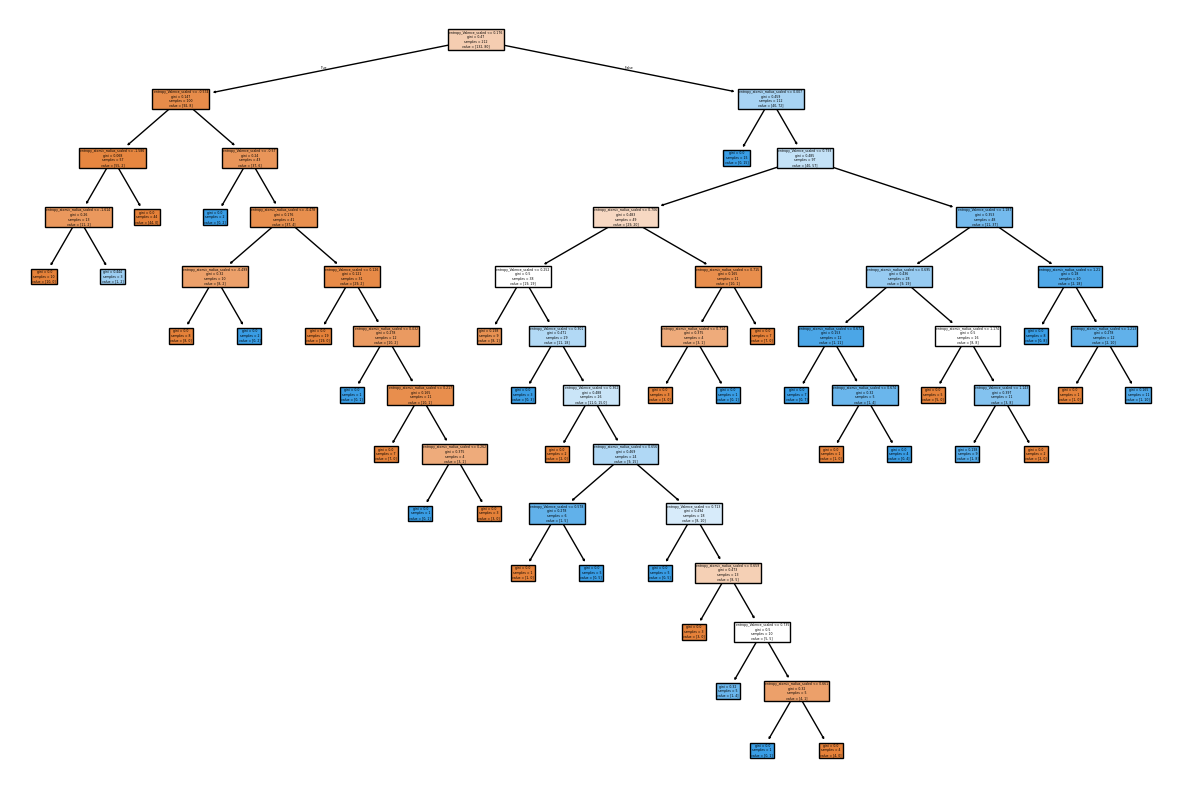

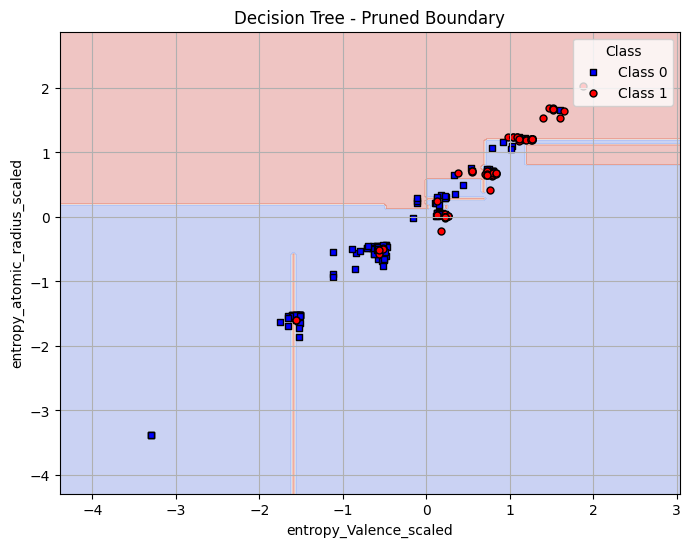

In [269]:
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
from sklearn.model_selection import LeaveOneOut, cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold

tree = DTC(random_state=42).fit(x_train, y_train)


plt.figure(figsize=(15,10))
plot_tree(tree, filled=True, feature_names=x_train.columns);

yhat0 = tree.predict(x_test)
acc0 = accuracy_score(y_test, yhat0)
f10 = f1_score(y_test, yhat0)

skf = StratifiedKFold(n_splits=4)
ccp = np.linspace(0.001, 0.2, 250)
cv_scores = []
for alpha in ccp:
  pruned_tree = DTC(random_state = 23,ccp_alpha=alpha)
  cv_scores.append(np.mean(cross_val_score(pruned_tree, x_train, y_train, cv=skf, scoring='f1')))
alpha = ccp[np.argmax(cv_scores)]
print("Best alpha:",alpha)
pruned_tree = DTC(random_state = 42,ccp_alpha=alpha).fit(x_train, y_train)
plot_tree(pruned_tree, filled=True, feature_names=x_train.columns);

x_min, x_max = x_train.iloc[:, 0].min() - 1, x_train.iloc[:, 0].max() + 1
y_min, y_max = x_train.iloc[:, 1].min() - 1, x_train.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])

Z = pruned_tree.predict(grid_df)
Z = Z.reshape(xx.shape)


plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

markers = {1: 'o', 0: 's'}
colors = {1: 'red', 0: 'blue'}
classes = {1: 'High', 0: 'Low'}
# Scatter plot of training data
for class_label in np.unique(y_train):
    plt.scatter(
        x_train.loc[y_train == class_label,'entropy_Valence_scaled'],
        x_train.loc[y_train == class_label, 'entropy_atomic_radius_scaled'],
        c=colors[class_label], marker=markers[class_label], edgecolor='k',
        label=f"Class {class_label}", s=25
    )

# Labels and legend
plt.xlabel("entropy_Valence_scaled")
plt.ylabel("entropy_atomic_radius_scaled")
plt.title("Decision Tree - Pruned Boundary")
plt.legend(title="Class", loc="upper right")
plt.grid(True)
plt.show()

**5.** Por último, se calcula **Accuracy, F1-score, Confusion Matrix** y un **reporte de Clasificación** para ambos modelos y así poder **compararlos**.

In [270]:
from sklearn.metrics import confusion_matrix, classification_report

yhat_lda = lda.predict(x_test)
acc_lda = accuracy_score(y_test, yhat_lda)
f1_lda = f1_score(y_test, yhat_lda)
print("Accuracy LDA:",acc_lda)
print("F1-score LDA:",f1_lda)

cm_lda = confusion_matrix(y_test, yhat_lda)
print(cm_lda)
rep_lda = classification_report(y_test, yhat_lda)
print(rep_lda)

yhat_p = pruned_tree.predict(x_test)
acc_p = accuracy_score(y_test, yhat_p)
f1_p = f1_score(y_test, yhat_p)
print("Accuracy Decision Tree:",acc_p)
print("F1-score Decision Tree:",f1_p)

cm_p = confusion_matrix(y_test, yhat_p)
print(cm_p)
rep_p = classification_report(y_test, yhat_p)
print(rep_p)

Accuracy LDA: 0.7950691178566339
F1-score LDA: 0.7572859232586925
[[10007  3109]
 [ 1205  6730]]
              precision    recall  f1-score   support

           0       0.89      0.76      0.82     13116
           1       0.68      0.85      0.76      7935

    accuracy                           0.80     21051
   macro avg       0.79      0.81      0.79     21051
weighted avg       0.81      0.80      0.80     21051

Accuracy Decision Tree: 0.7952591325827751
F1-score Decision Tree: 0.7468577469752143
[[10383  2733]
 [ 1577  6358]]
              precision    recall  f1-score   support

           0       0.87      0.79      0.83     13116
           1       0.70      0.80      0.75      7935

    accuracy                           0.80     21051
   macro avg       0.78      0.80      0.79     21051
weighted avg       0.80      0.80      0.80     21051



Sobre los datos obtenidos se puede decir que tienen un **accuracy similar** por lo cual en **clasificación en general** dan resultados similares.

El **f1-score** del modelo de **LDA es ligeramente superior** al del árbol de decisión, por lo cual tiene **mejor balance entre precisión y sensibilidad**.

Sobre las **matrices de confusión**, el modelo de **lda es mejor para identificar cuando la temperatura crítica es alta** ya que tiene **menos falsos negativos**.

Por otro lado, el **modelo de árbol de decisión tiene menos falsos positivos**. Para este estudio, **falsos positivos pueden llegar a ser más costosos** al utilizar recursos de investigación, por lo cuál sería **mejor el modelo de árbol de decisión** al cometer **menos falsos positivos**.

Por último, del **reporte de clasificación**, se observa que **lda es mejor para encontrar positivos**, y **árbol de decisión es mejor para detectar negativos**. Por lo cual se confirma lo visto en la matriz de confusión.

Para un posible uso en el estudio sobre **materiales superconductores y sus temperaturas críticas**, para evitar falsos positivos, **sería mejor utilizar el modelo generado por árbol de decisión**.